In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import multiprocessing as mp
import pathlib as pl
import pickle

import pandas as pd

from smlm import plot
from smlm import helpers
from smlm import stats
from smlm import config as smlm_config
from smlm.styles import prism
from smlm.orte import Orte

prism.prism_style()

In [3]:
# font_paths = mpf.findSystemFonts()
# font_objects = mpf.createFontList(font_paths)
# font_names = [f.name for f in font_objects]

In [4]:
recalculate_voronoi = False
# recalculate_voronoi = True
# figure_base_size = 6.5
# dpi = 300
# figure_file_type = "svg"

stage_method = smlm_config.STAGE_METHOD
method_display = "Eye based, 5 Stages"

result_dir = pl.Path("results/paper")
result_dir_fig5 = result_dir.joinpath("fig5")

helpers.assure_dir(result_dir_fig5)

labelling = "H2B_mCherry"
# labelling = "SO_dissociated_neurons"
# labelling = "SO_tissue"
thunderstorm_param_1 = "1_0"
# thunderstorm_param_1 = "0_7"
thunderstorm_param_2 = "merge_filter"

data_dir = pl.Path("data/cut_cells")

raw_orte_paths = [path for path in data_dir.glob(f"{labelling}/*/{thunderstorm_param_1}/{thunderstorm_param_2}/*.csv")]
labelling_csv = pl.Path("data/cut_cells/cell_classification_manual_master_5_stage.csv")



## Labelling

In [5]:
raw_stages = pd.read_csv(labelling_csv,
                         names=["file", "manual_stage", "confocal_stage", "automatic_stage",
                                "manual_5_stage", "ilastik_stage", "conf_ccp", "labelling", "include"],
                         dtype={"manual_stage": "Int64", "confocal_stage": "Int64",
                                "automatic_stage": "Int64", "manual_5_stage": "Int64",
                                "ilastik_stage": "Int64", "include": bool})

### Pre-Filtering cells

In [6]:
filtered_stages = raw_stages.loc[raw_stages.include]
filtered_stages


,file,manual_stage,confocal_stage,automatic_stage,manual_5_stage,ilastik_stage,conf_ccp,labelling,include
0,9_thre_1_0_recon_merge_filter_cut.csv,1,1,<NA>,1,1,3.548387,H2B_mCherry,True
4,cell_N_thre_1_0_recon_merge_2ndfilter.csv,5,4,<NA>,3,3,16.481069,H2B_mCherry,True
5,M_1_thre_1_0_recon_merge_filter.csv,5,5,<NA>,3,3,20.249221,H2B_mCherry,True
9,s03_L_2_recon_1_0_thre_merge_filter.csv,2,3,<NA>,2,2,13.575865,H2B_mCherry,True
11,s01_10_cell1_recon_1_0_thre_merge_filter.csv,1,1,<NA>,1,1,2.956225,H2B_mCherry,True
12,s01_10_cell2_recon_1_0_thre_merge_filter.csv,1,1,<NA>,1,1,2.540835,H2B_mCherry,True
13,s02_L_cell3_recon_1_0_thre_merge_filter.csv,1,1,<NA>,1,1,4.661326,H2B_mCherry,True
14,s02_L_cell4_recon_1_0_thre_merge_filter.csv,1,1,<NA>,1,1,4.193971,H2B_mCherry,True
18,s01_recon_1_0_thre_merge_filter.csv,1,1,<NA>,1,1,4.440497,H2B_mCherry,True
19,s02_recon_1_0_thre_merge_filter_cut.csv,1,1,<NA>,1,1,3.358925,H2B_mCherry,True


In [7]:
orte_paths = [raw_orte_path for raw_orte_path in raw_orte_paths if raw_orte_path.name in raw_stages.file.to_list()]


In [8]:
voronoi_orte_file_path = result_dir.joinpath("voronoi_orte.p")
if voronoi_orte_file_path.exists() and not recalculate_voronoi:
    raw_all_cells, raw_all_clusters = pickle.load(voronoi_orte_file_path.open("rb"))

else:
    # with mp.Pool(processes=1) as p:
    with mp.Pool(processes=min(len(orte_paths), mp.cpu_count())) as p:
        orte_list = p.map(Orte, orte_paths, chunksize=1)

    raw_all_cells = pd.DataFrame()
    raw_all_clusters = pd.DataFrame()
    for orte in orte_list:
        raw_all_cells = raw_all_cells.append(orte.orte_df)
        raw_all_clusters = raw_all_clusters.append(orte.get_named_cluster_meta("dbscan"))

    with voronoi_orte_file_path.open("wb") as vof:
        pickle.dump((raw_all_cells, raw_all_clusters), vof)

    del orte
    del orte_list


In [9]:
all_cells = helpers.merge_localizations_stages(raw_all_cells, raw_stages)
all_clusters = helpers.merge_localizations_stages(raw_all_clusters, raw_stages)

In [10]:
filtered_cells = helpers.merge_localizations_stages(raw_all_cells, filtered_stages, (stage_method,))
filtered_clusters = helpers.merge_localizations_stages(raw_all_clusters, filtered_stages, (stage_method,))

In [11]:
del raw_all_cells
del raw_all_clusters

## Figure 4

Density histogram by apoptotic stage

In [12]:
plot_col = smlm_config.LOG_NORM_DENS_COL
plot_label = smlm_config.LOG_NORM_DENS_LABEL

density_lims = smlm_config.DENSITY_LIM

n_stages = plot.get_n_stages(stage_method, raw_stages)

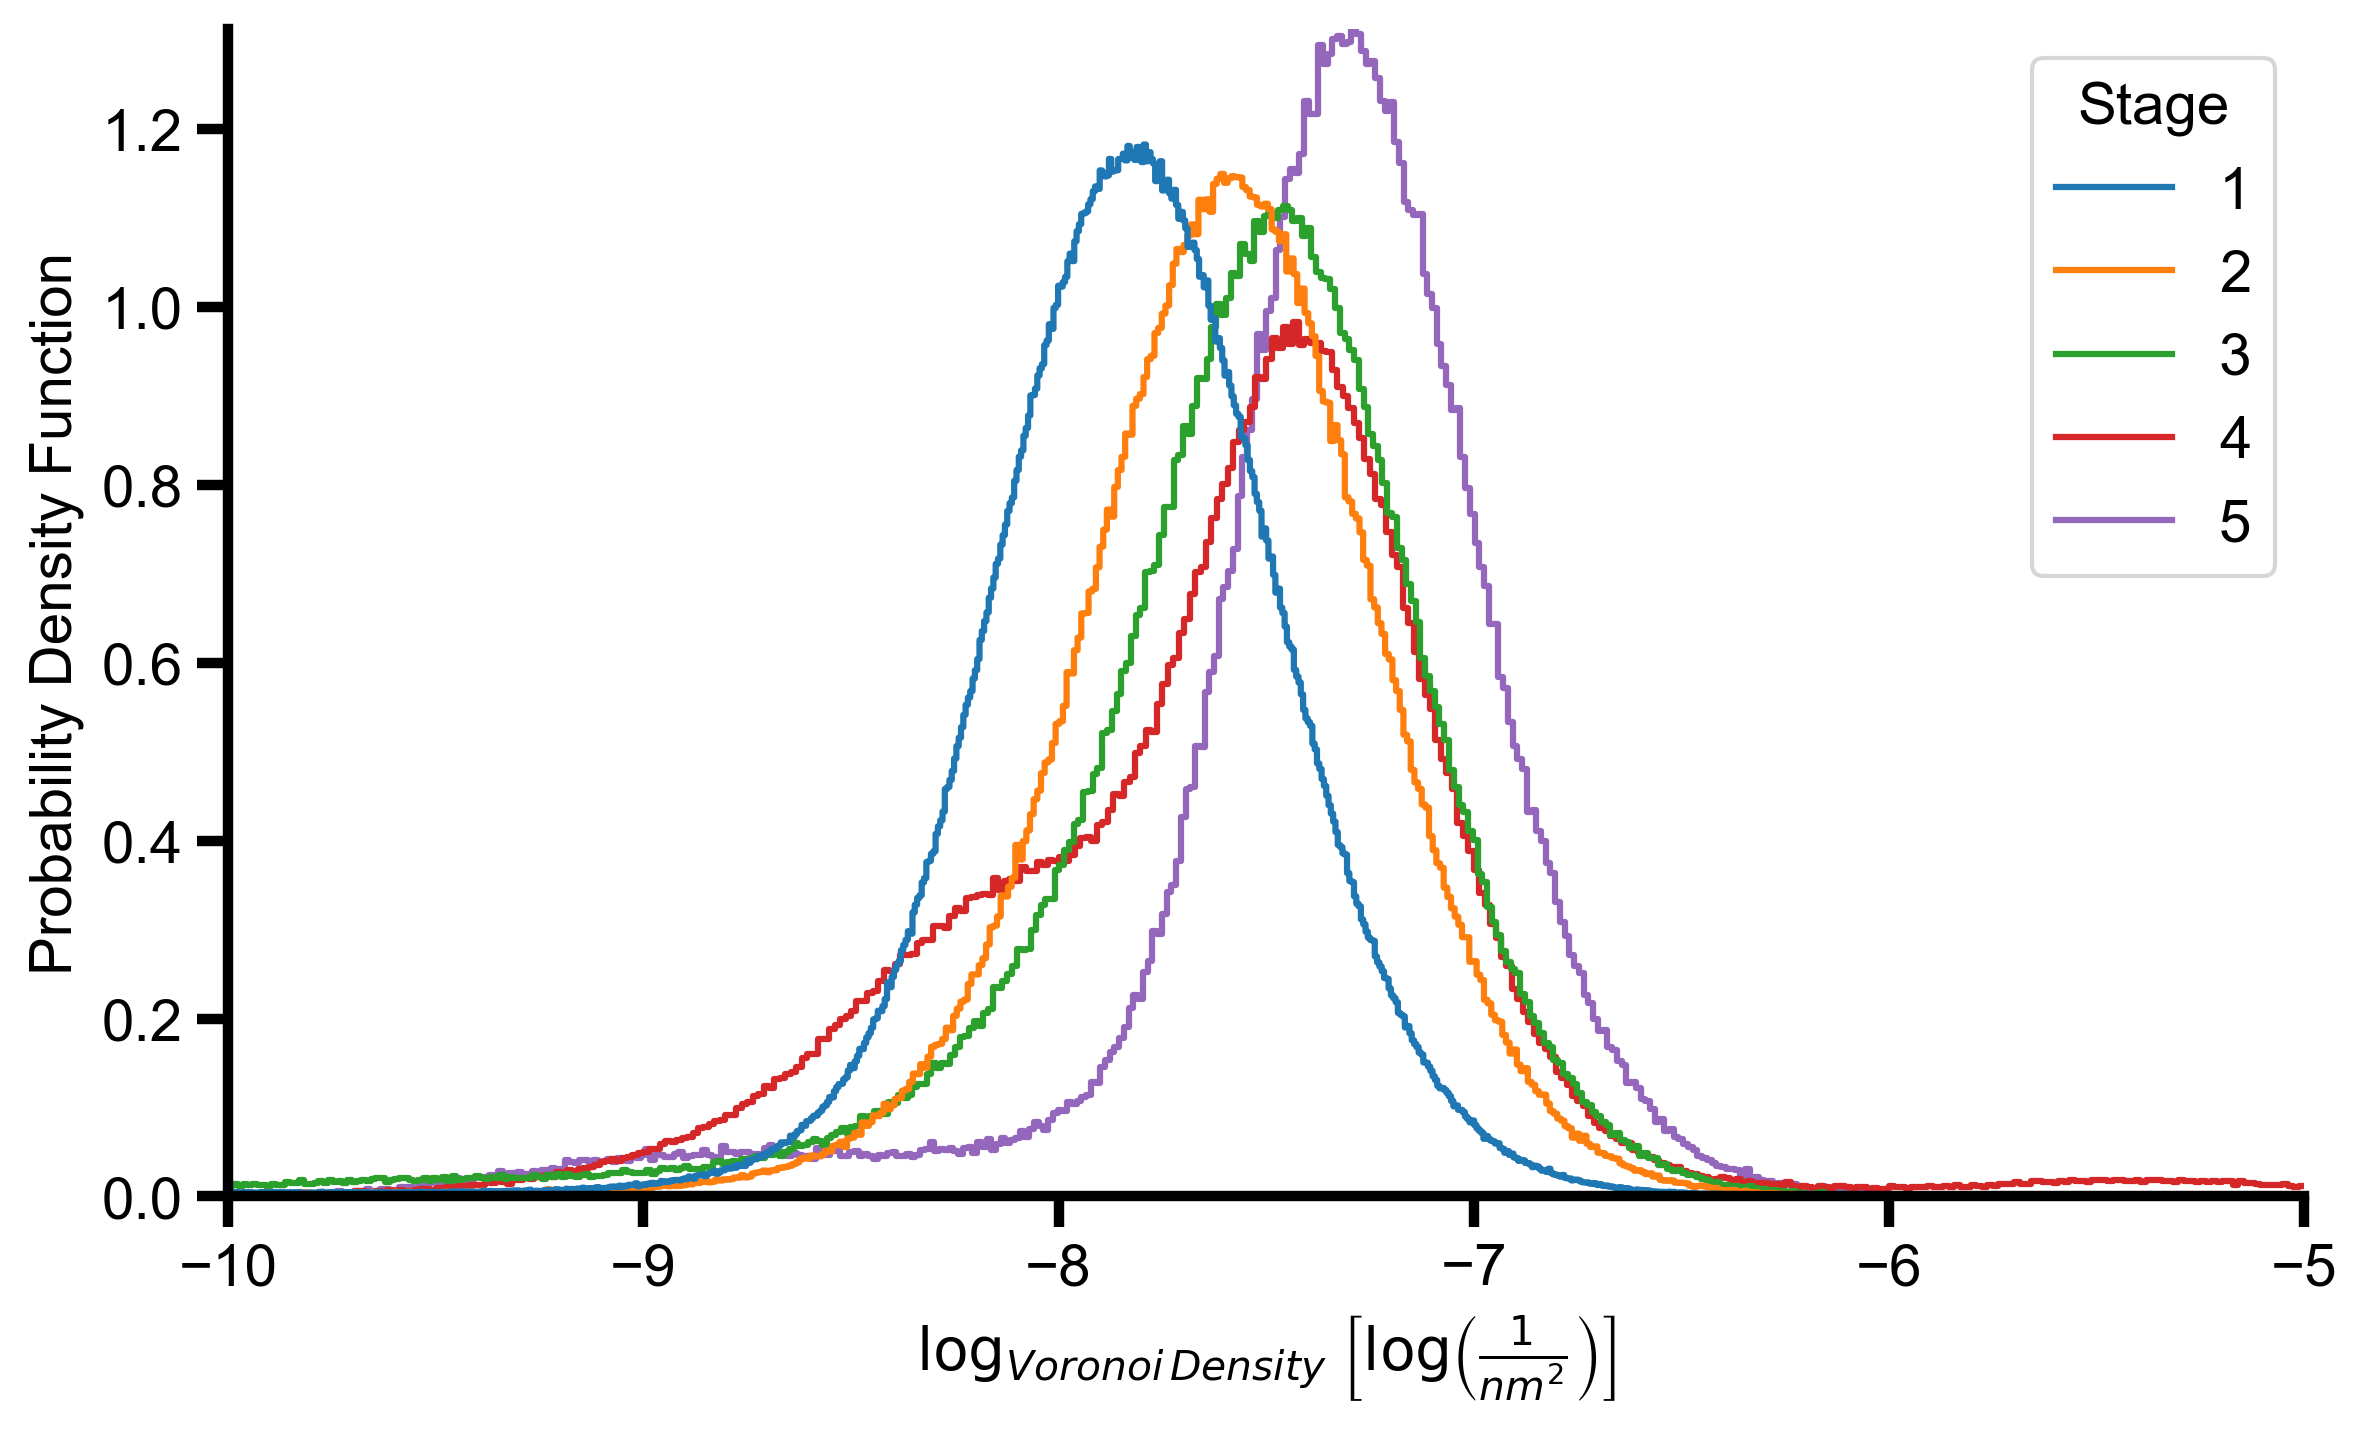

In [13]:
# sns.set(font="Times New Roman")
fig, ax = plot.plot_stage_histogram(plot_col=plot_col, method=stage_method, data=filtered_cells,
                                    plot_label=plot_label, method_label=method_display,
                                    density_lims=density_lims,
                                    n_stages=n_stages)
# ax.spines["left"].set_linewidth(2)

# sns.despine(fig)
ax.margins(0)

fig.savefig(result_dir_fig5.joinpath(f"stage_{plot_col}_{stage_method}.{smlm_config.FIG_TYPE}"))

Radius - Density histogram by apoptotic stage

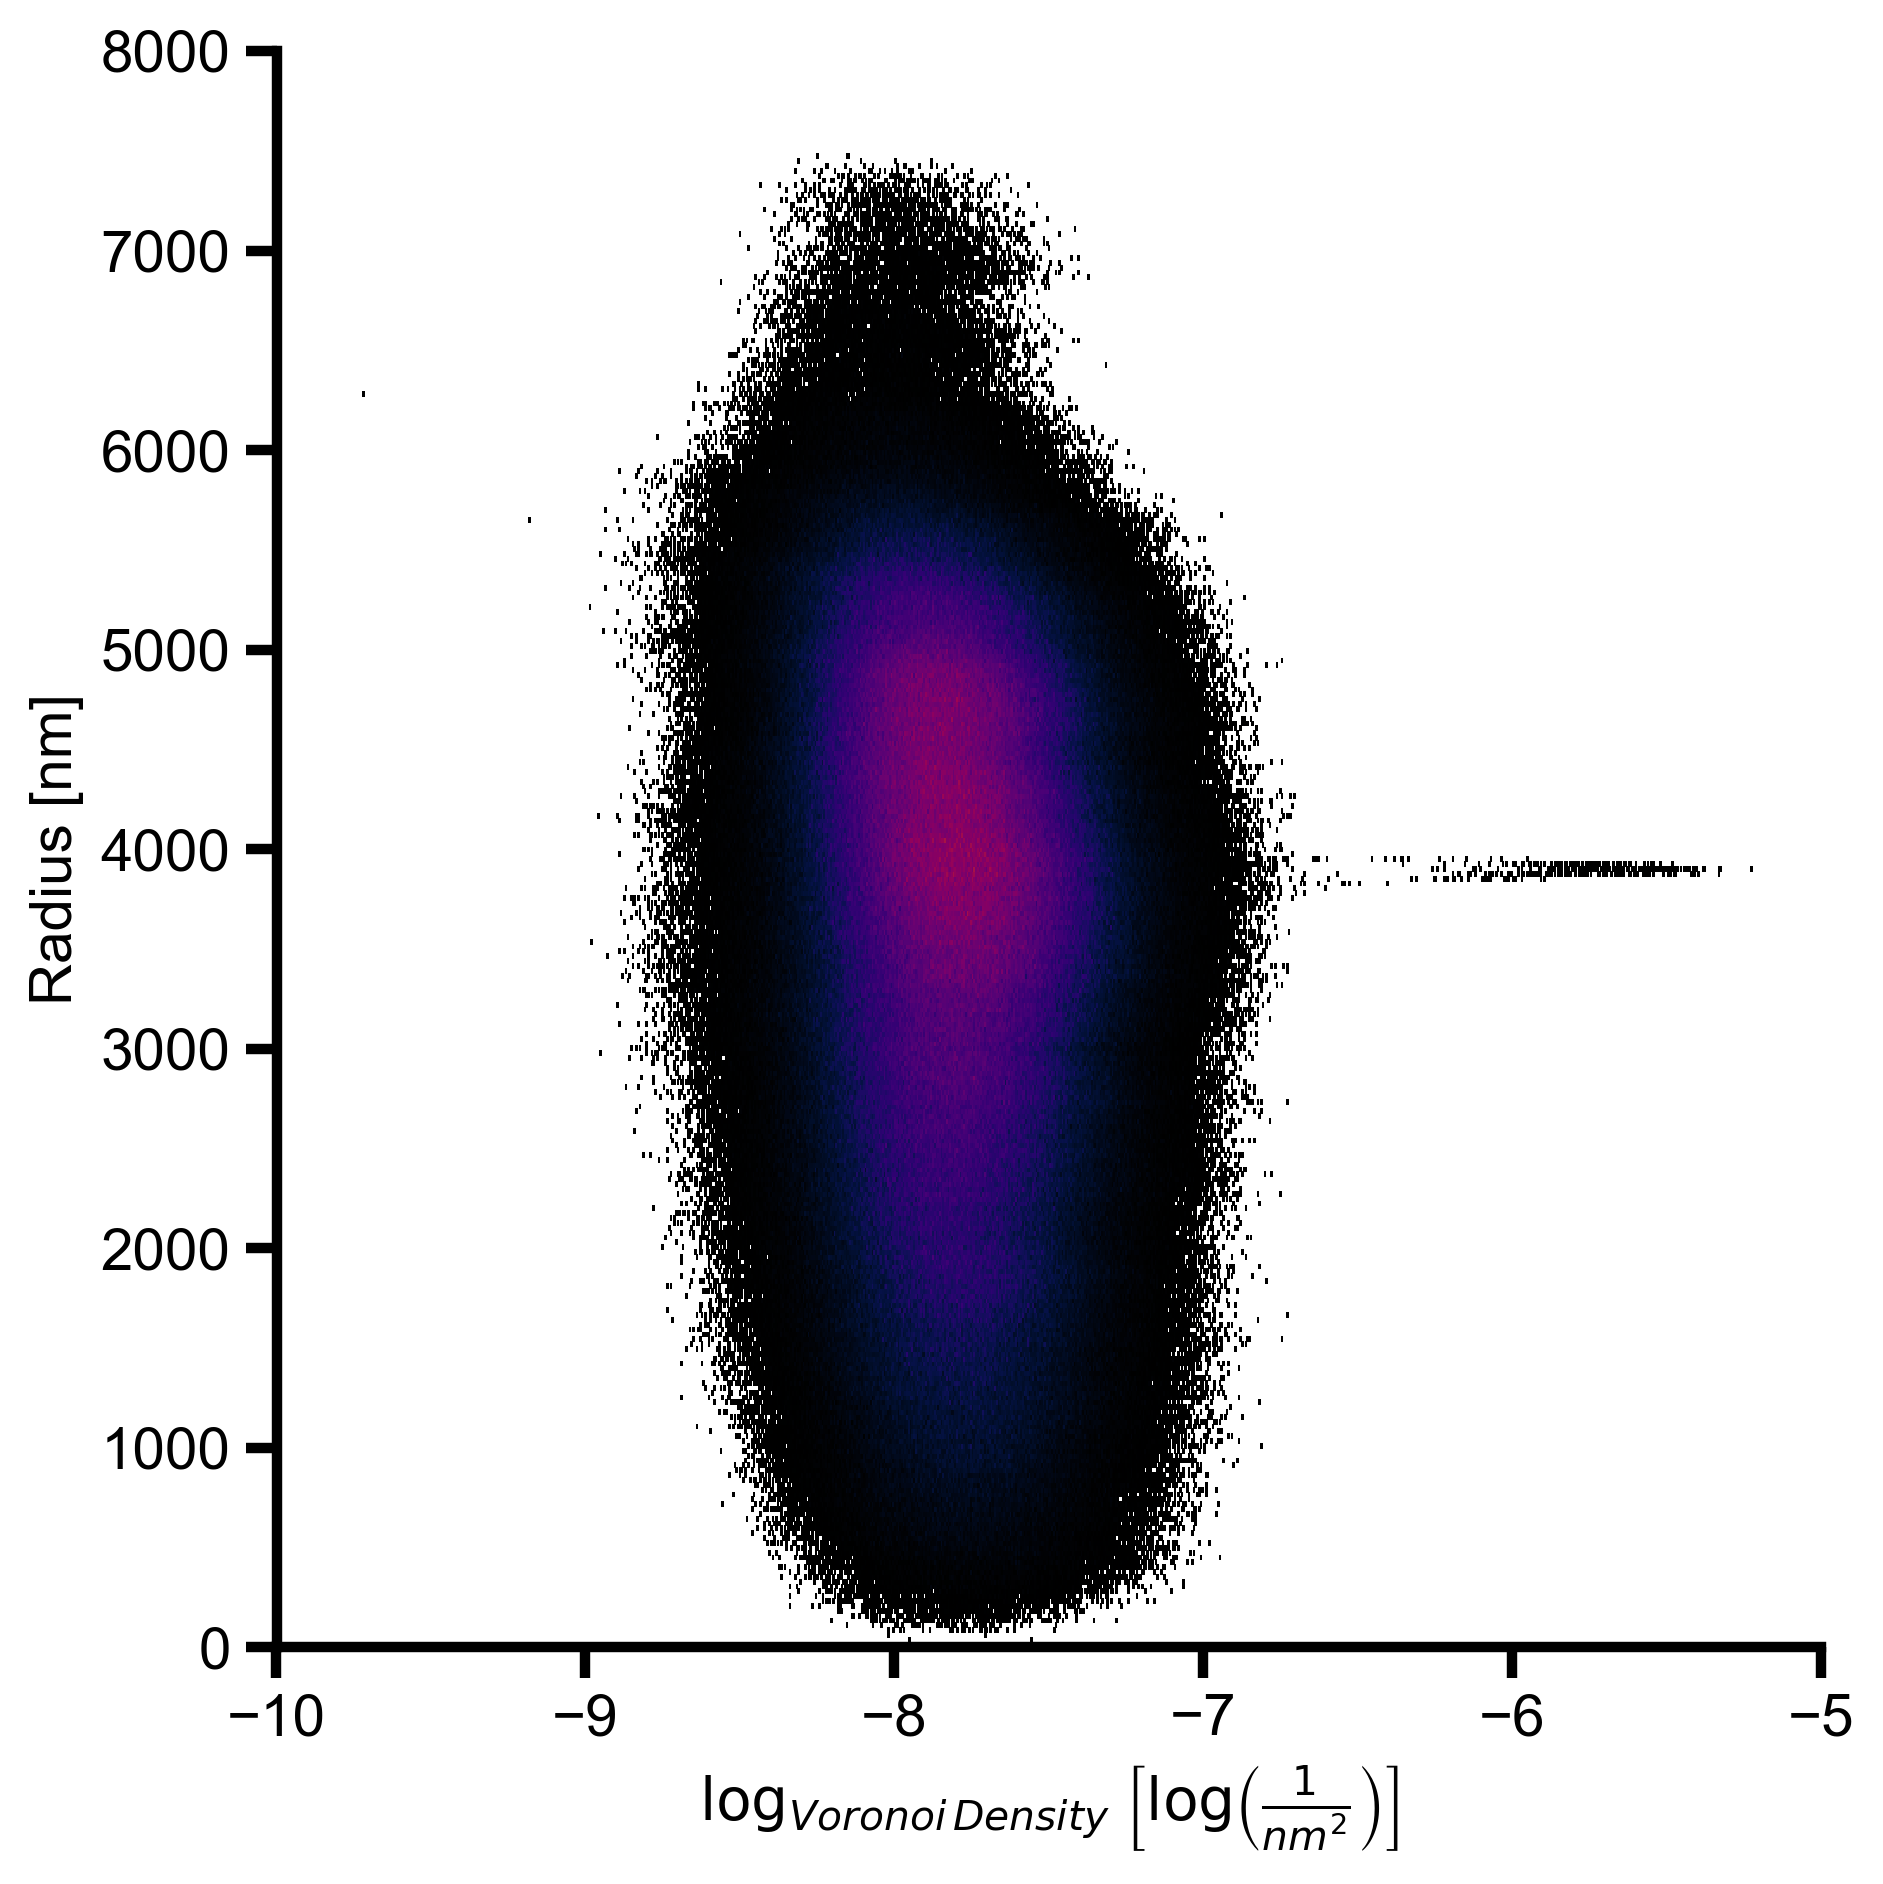

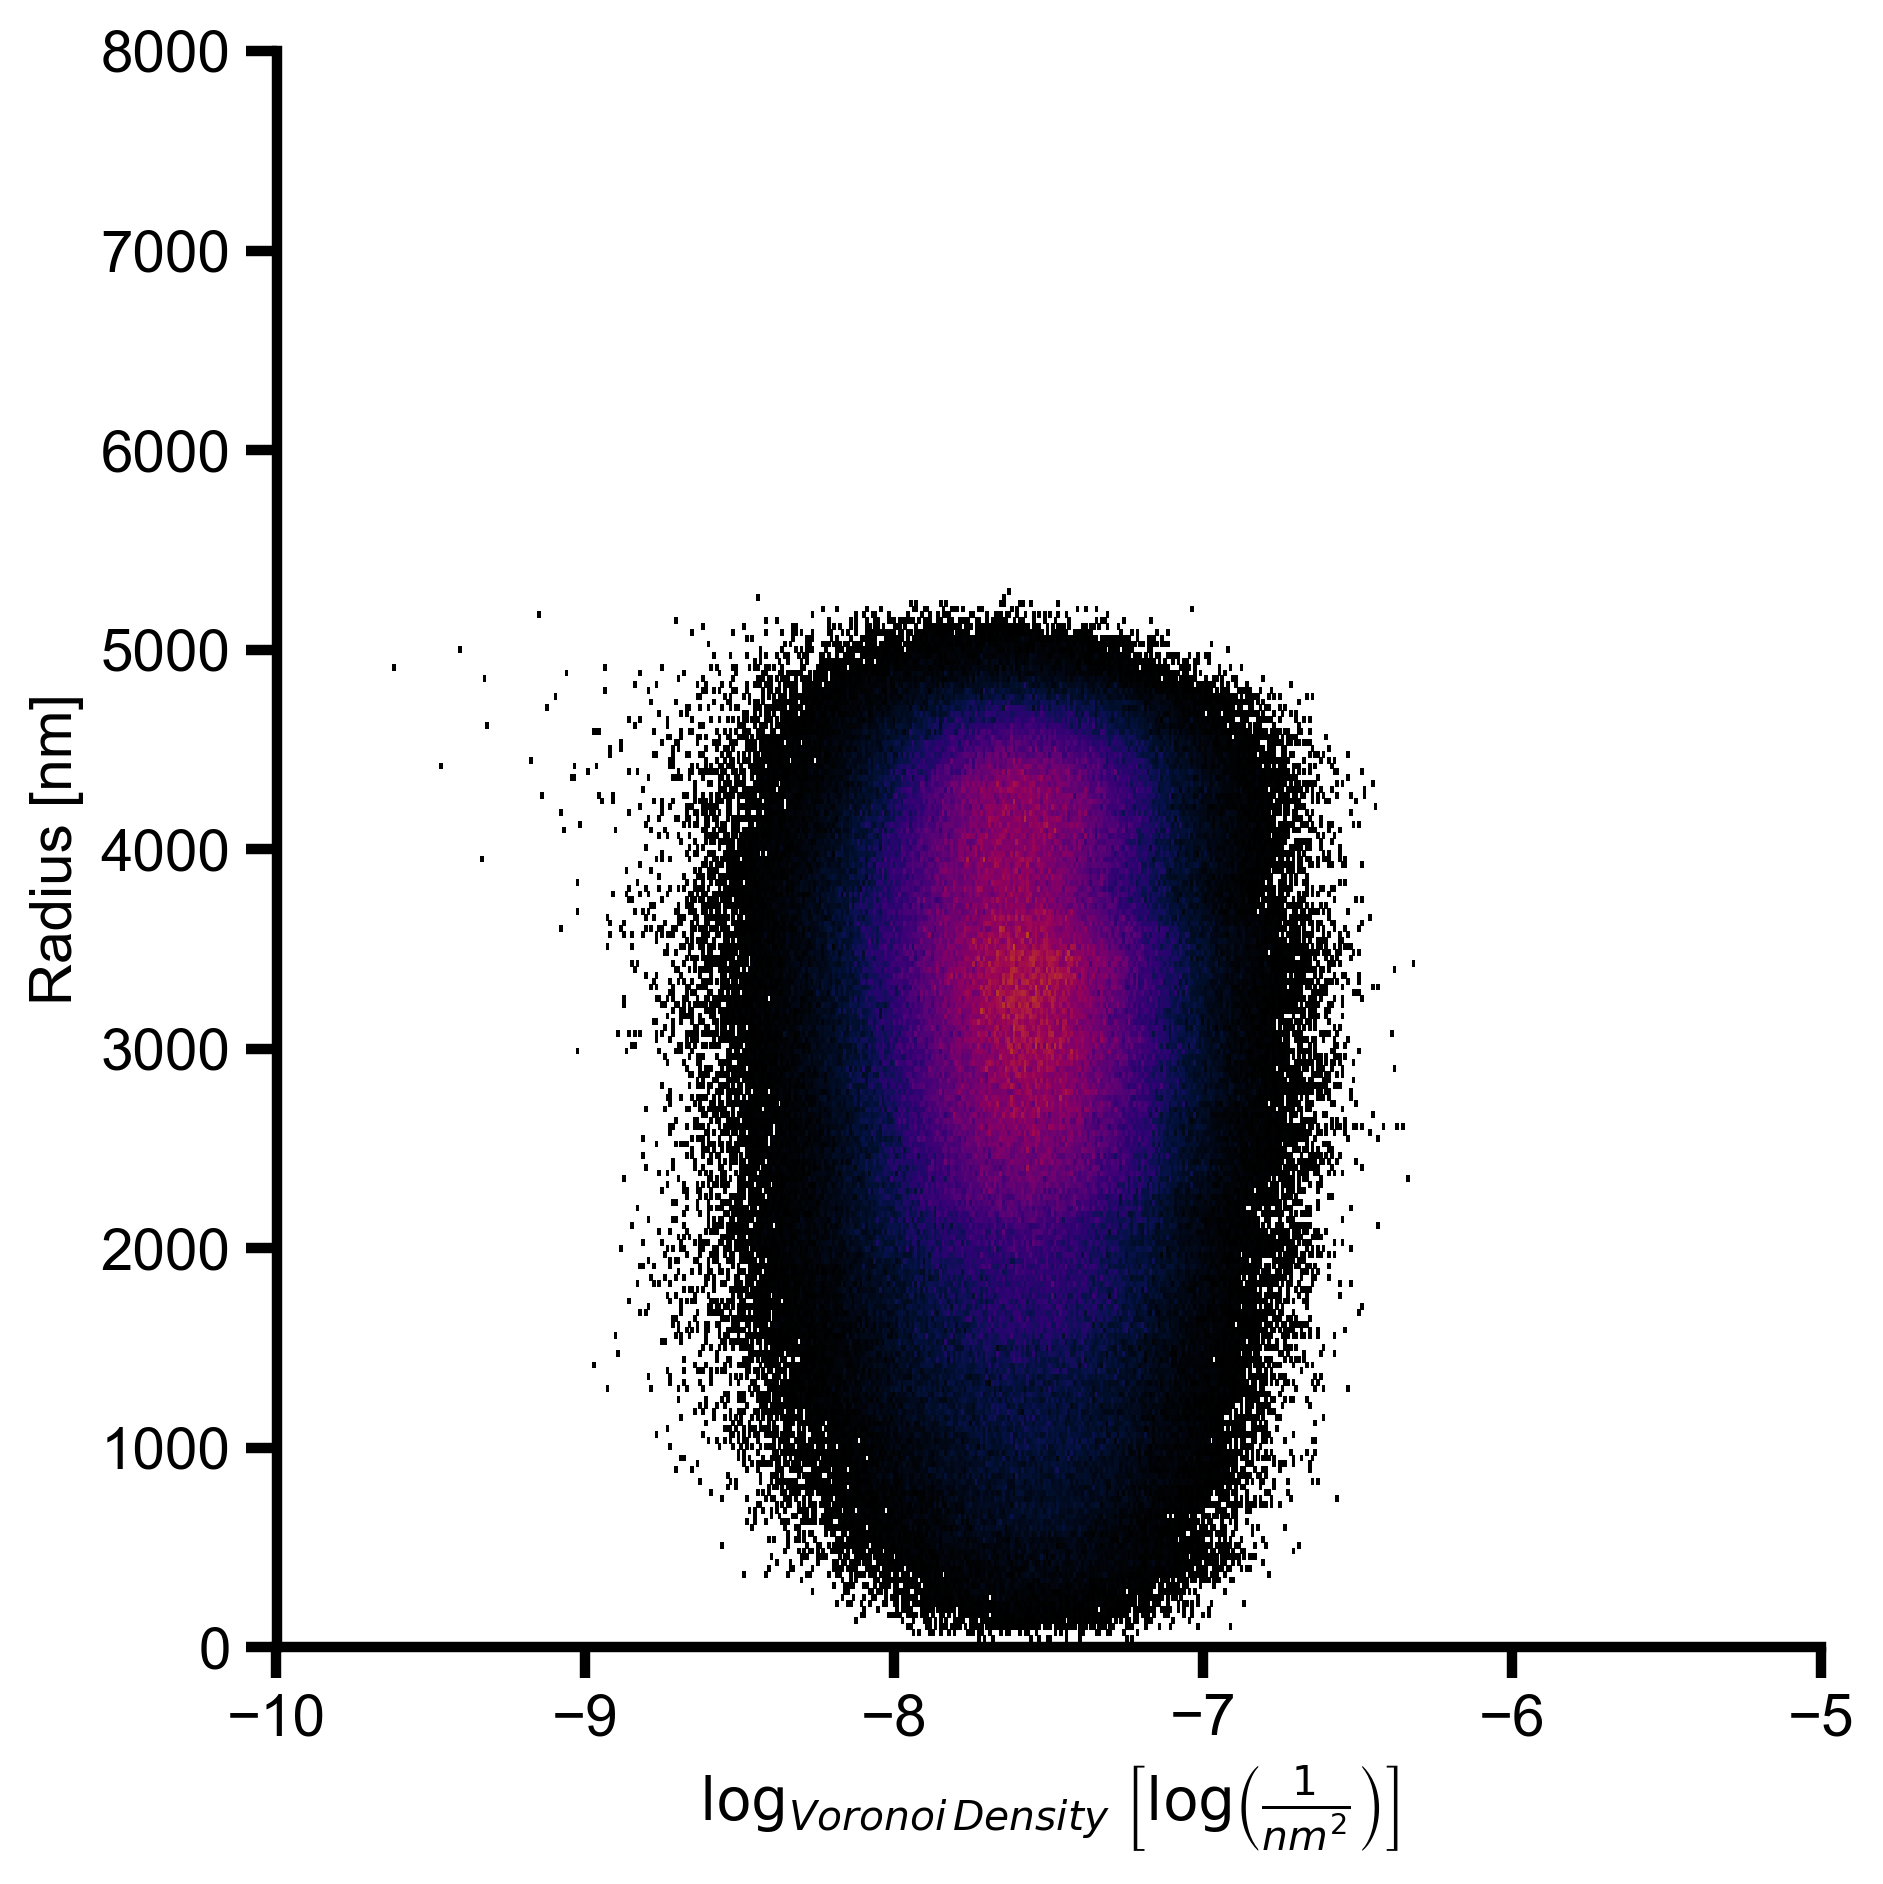

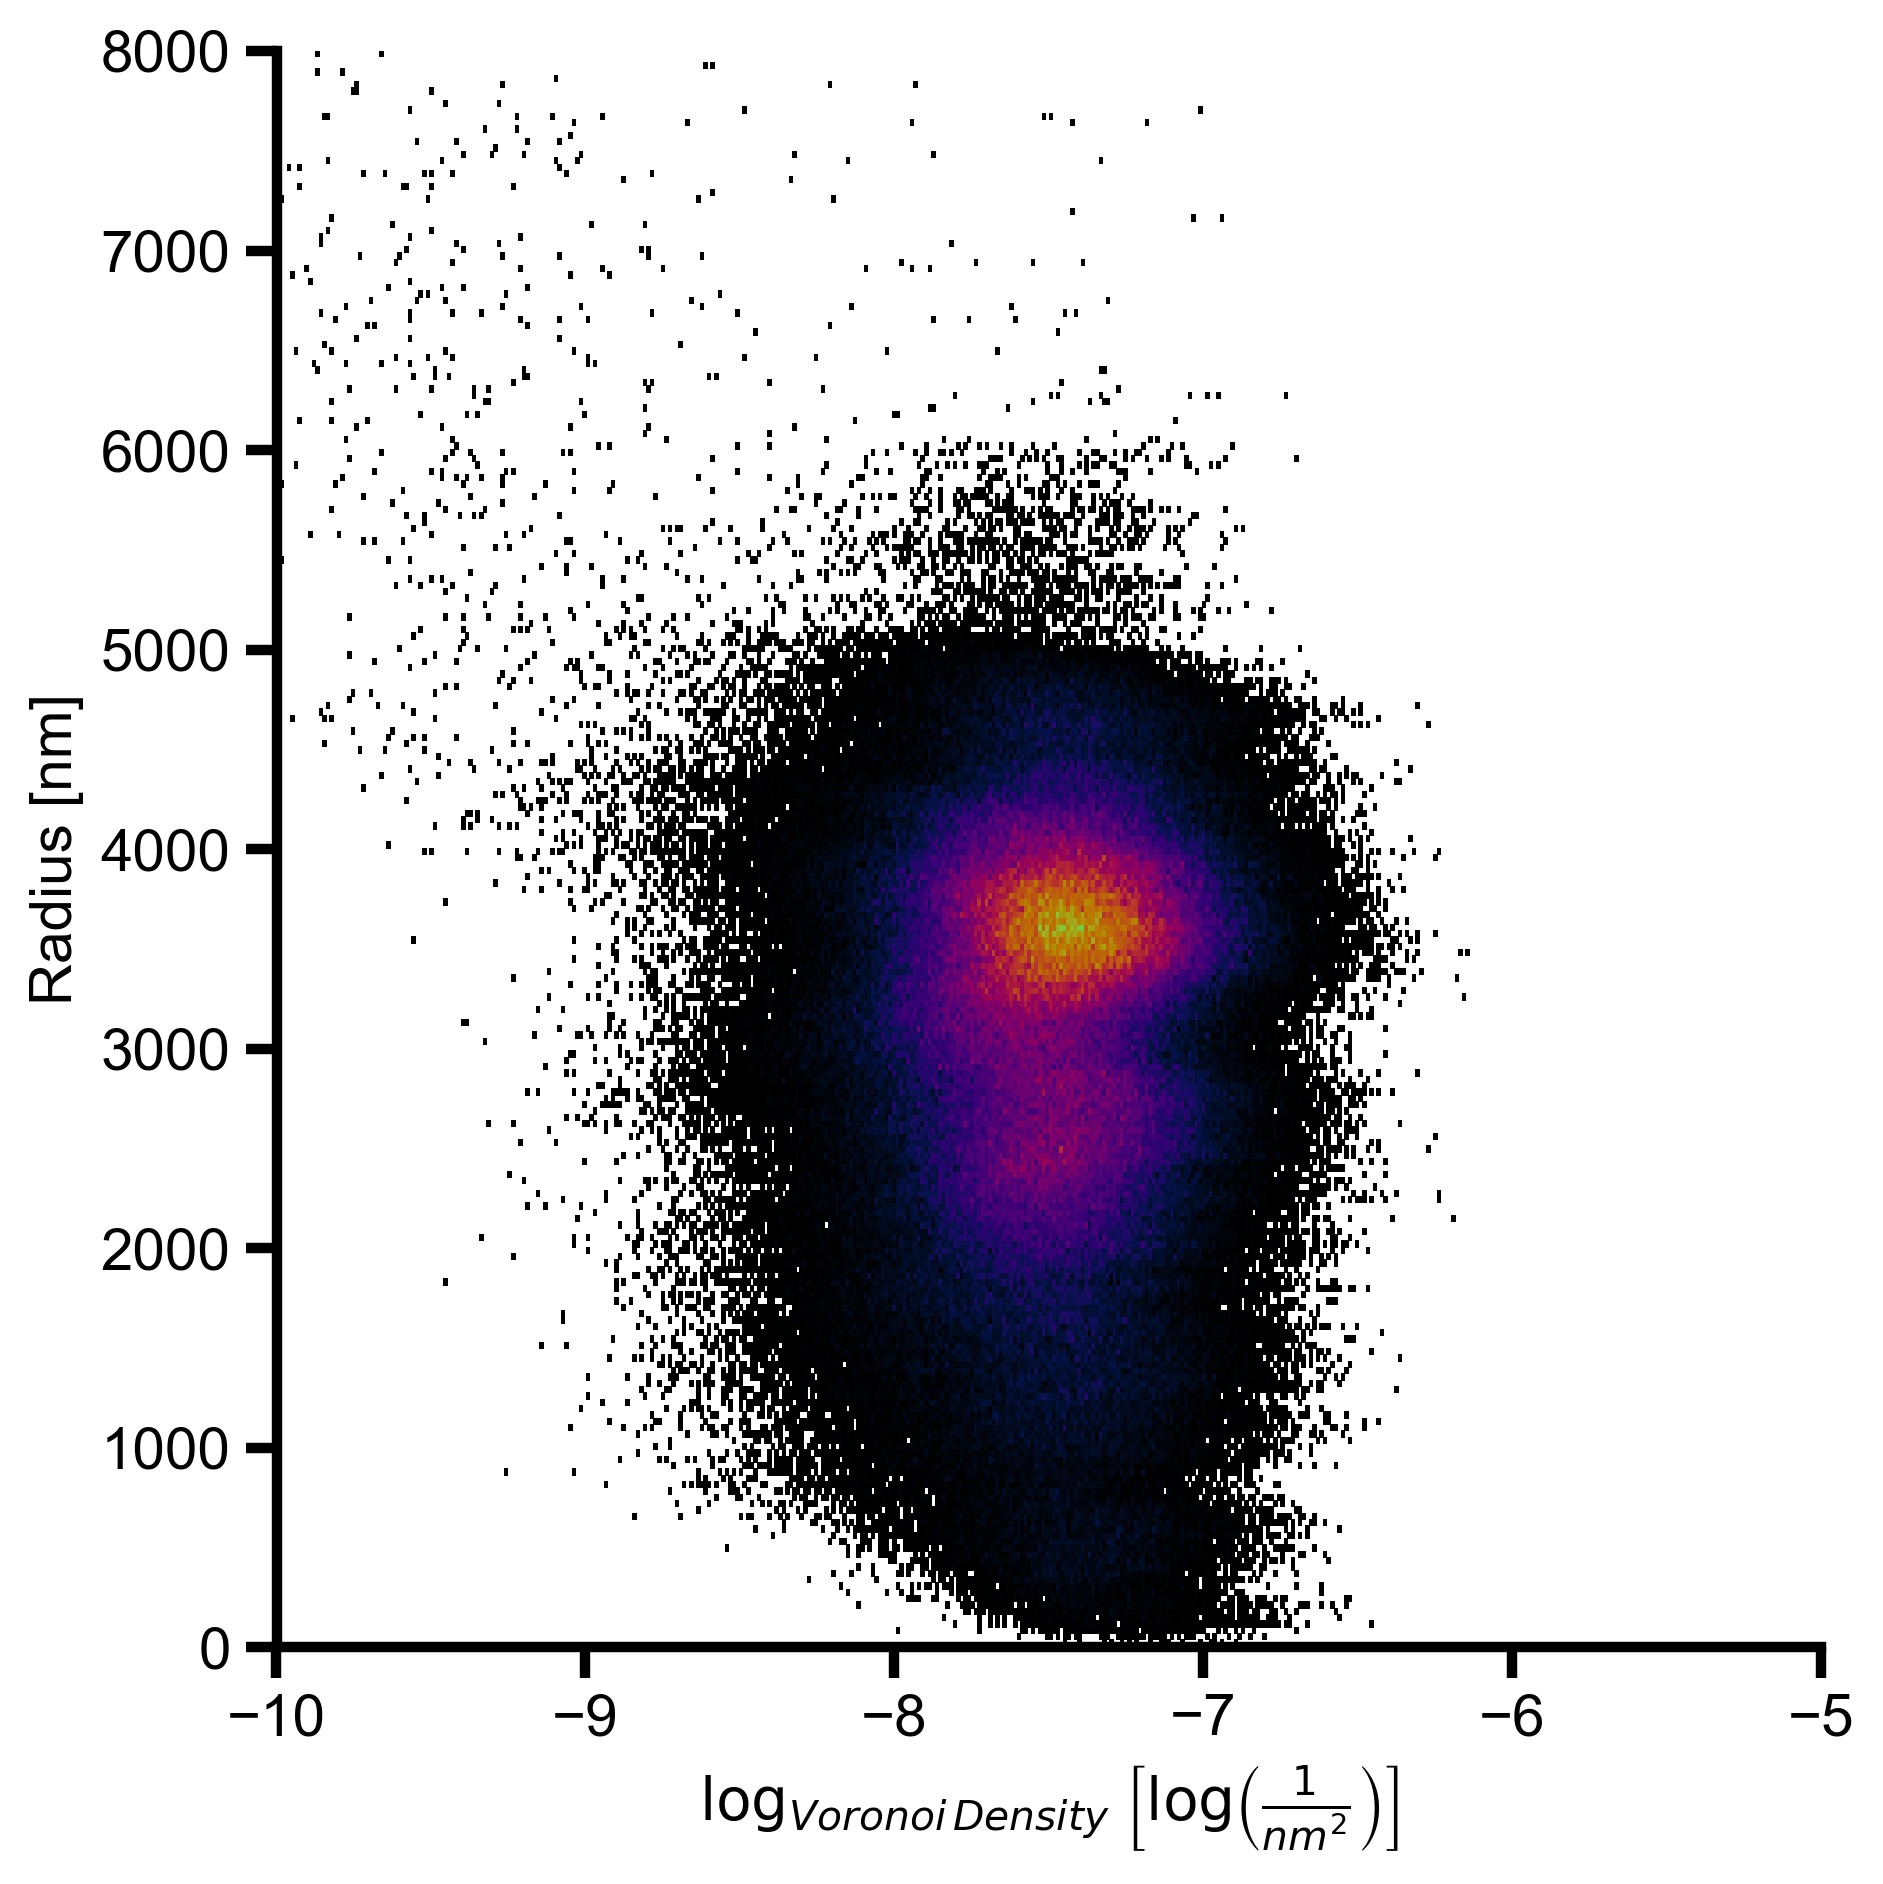

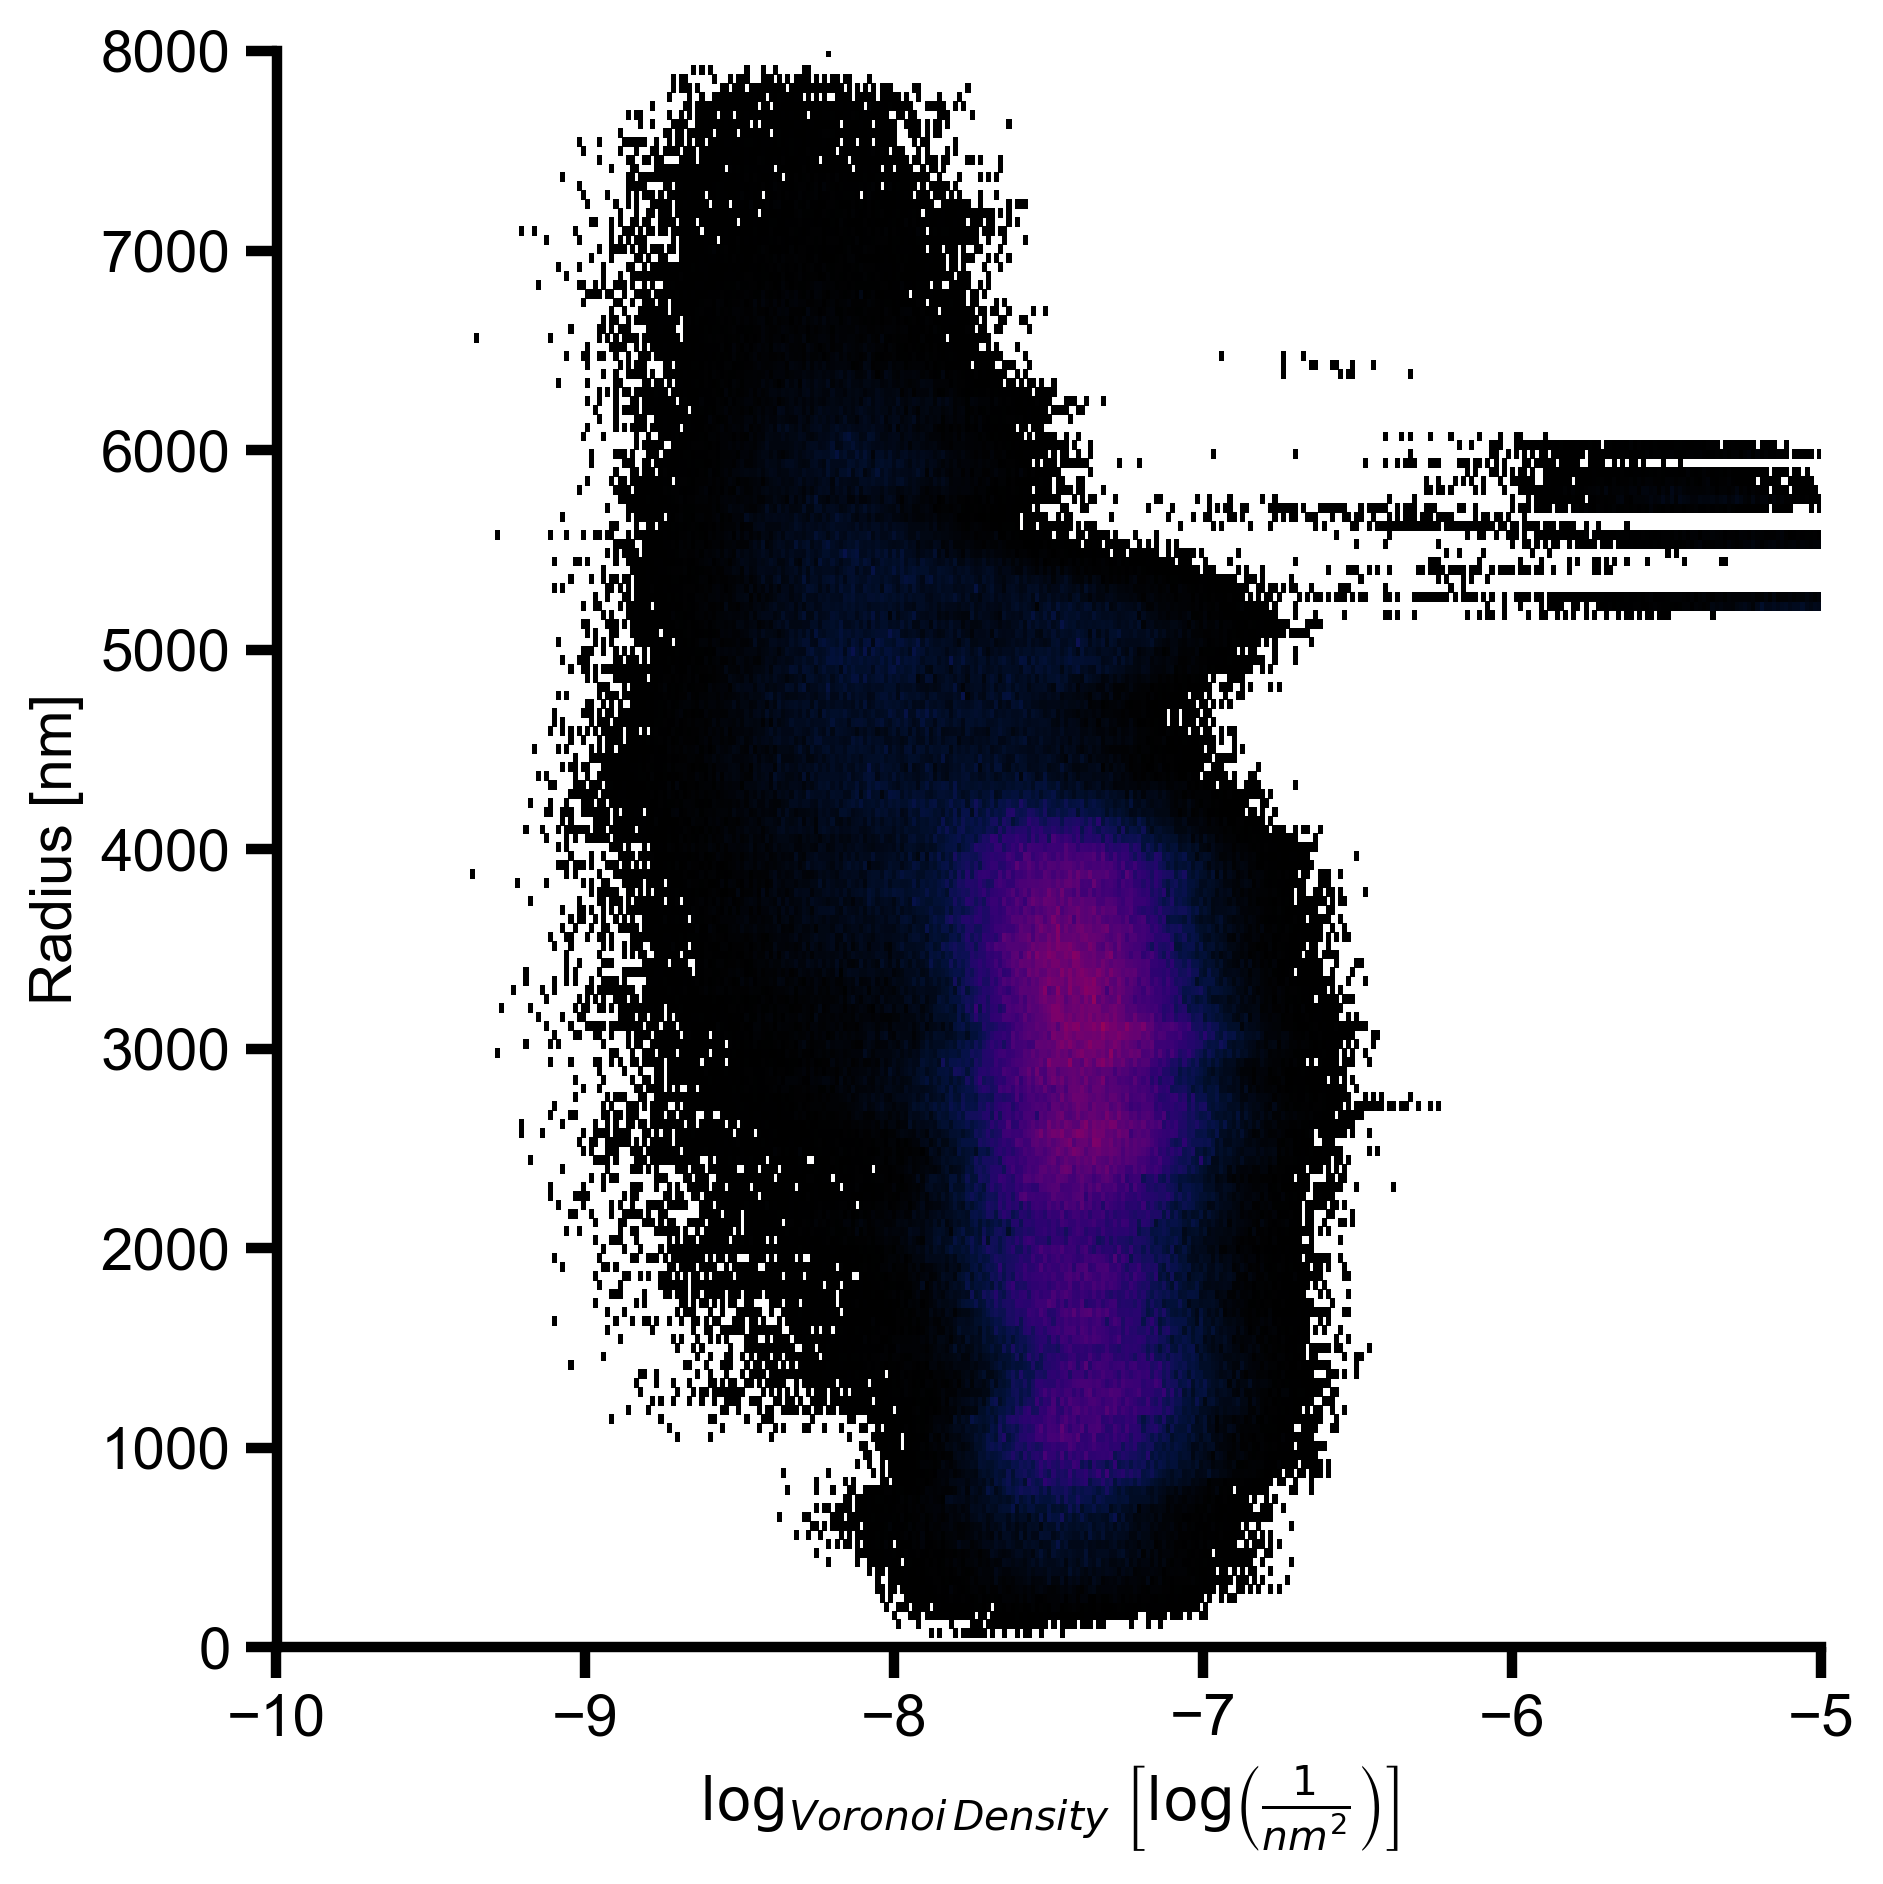

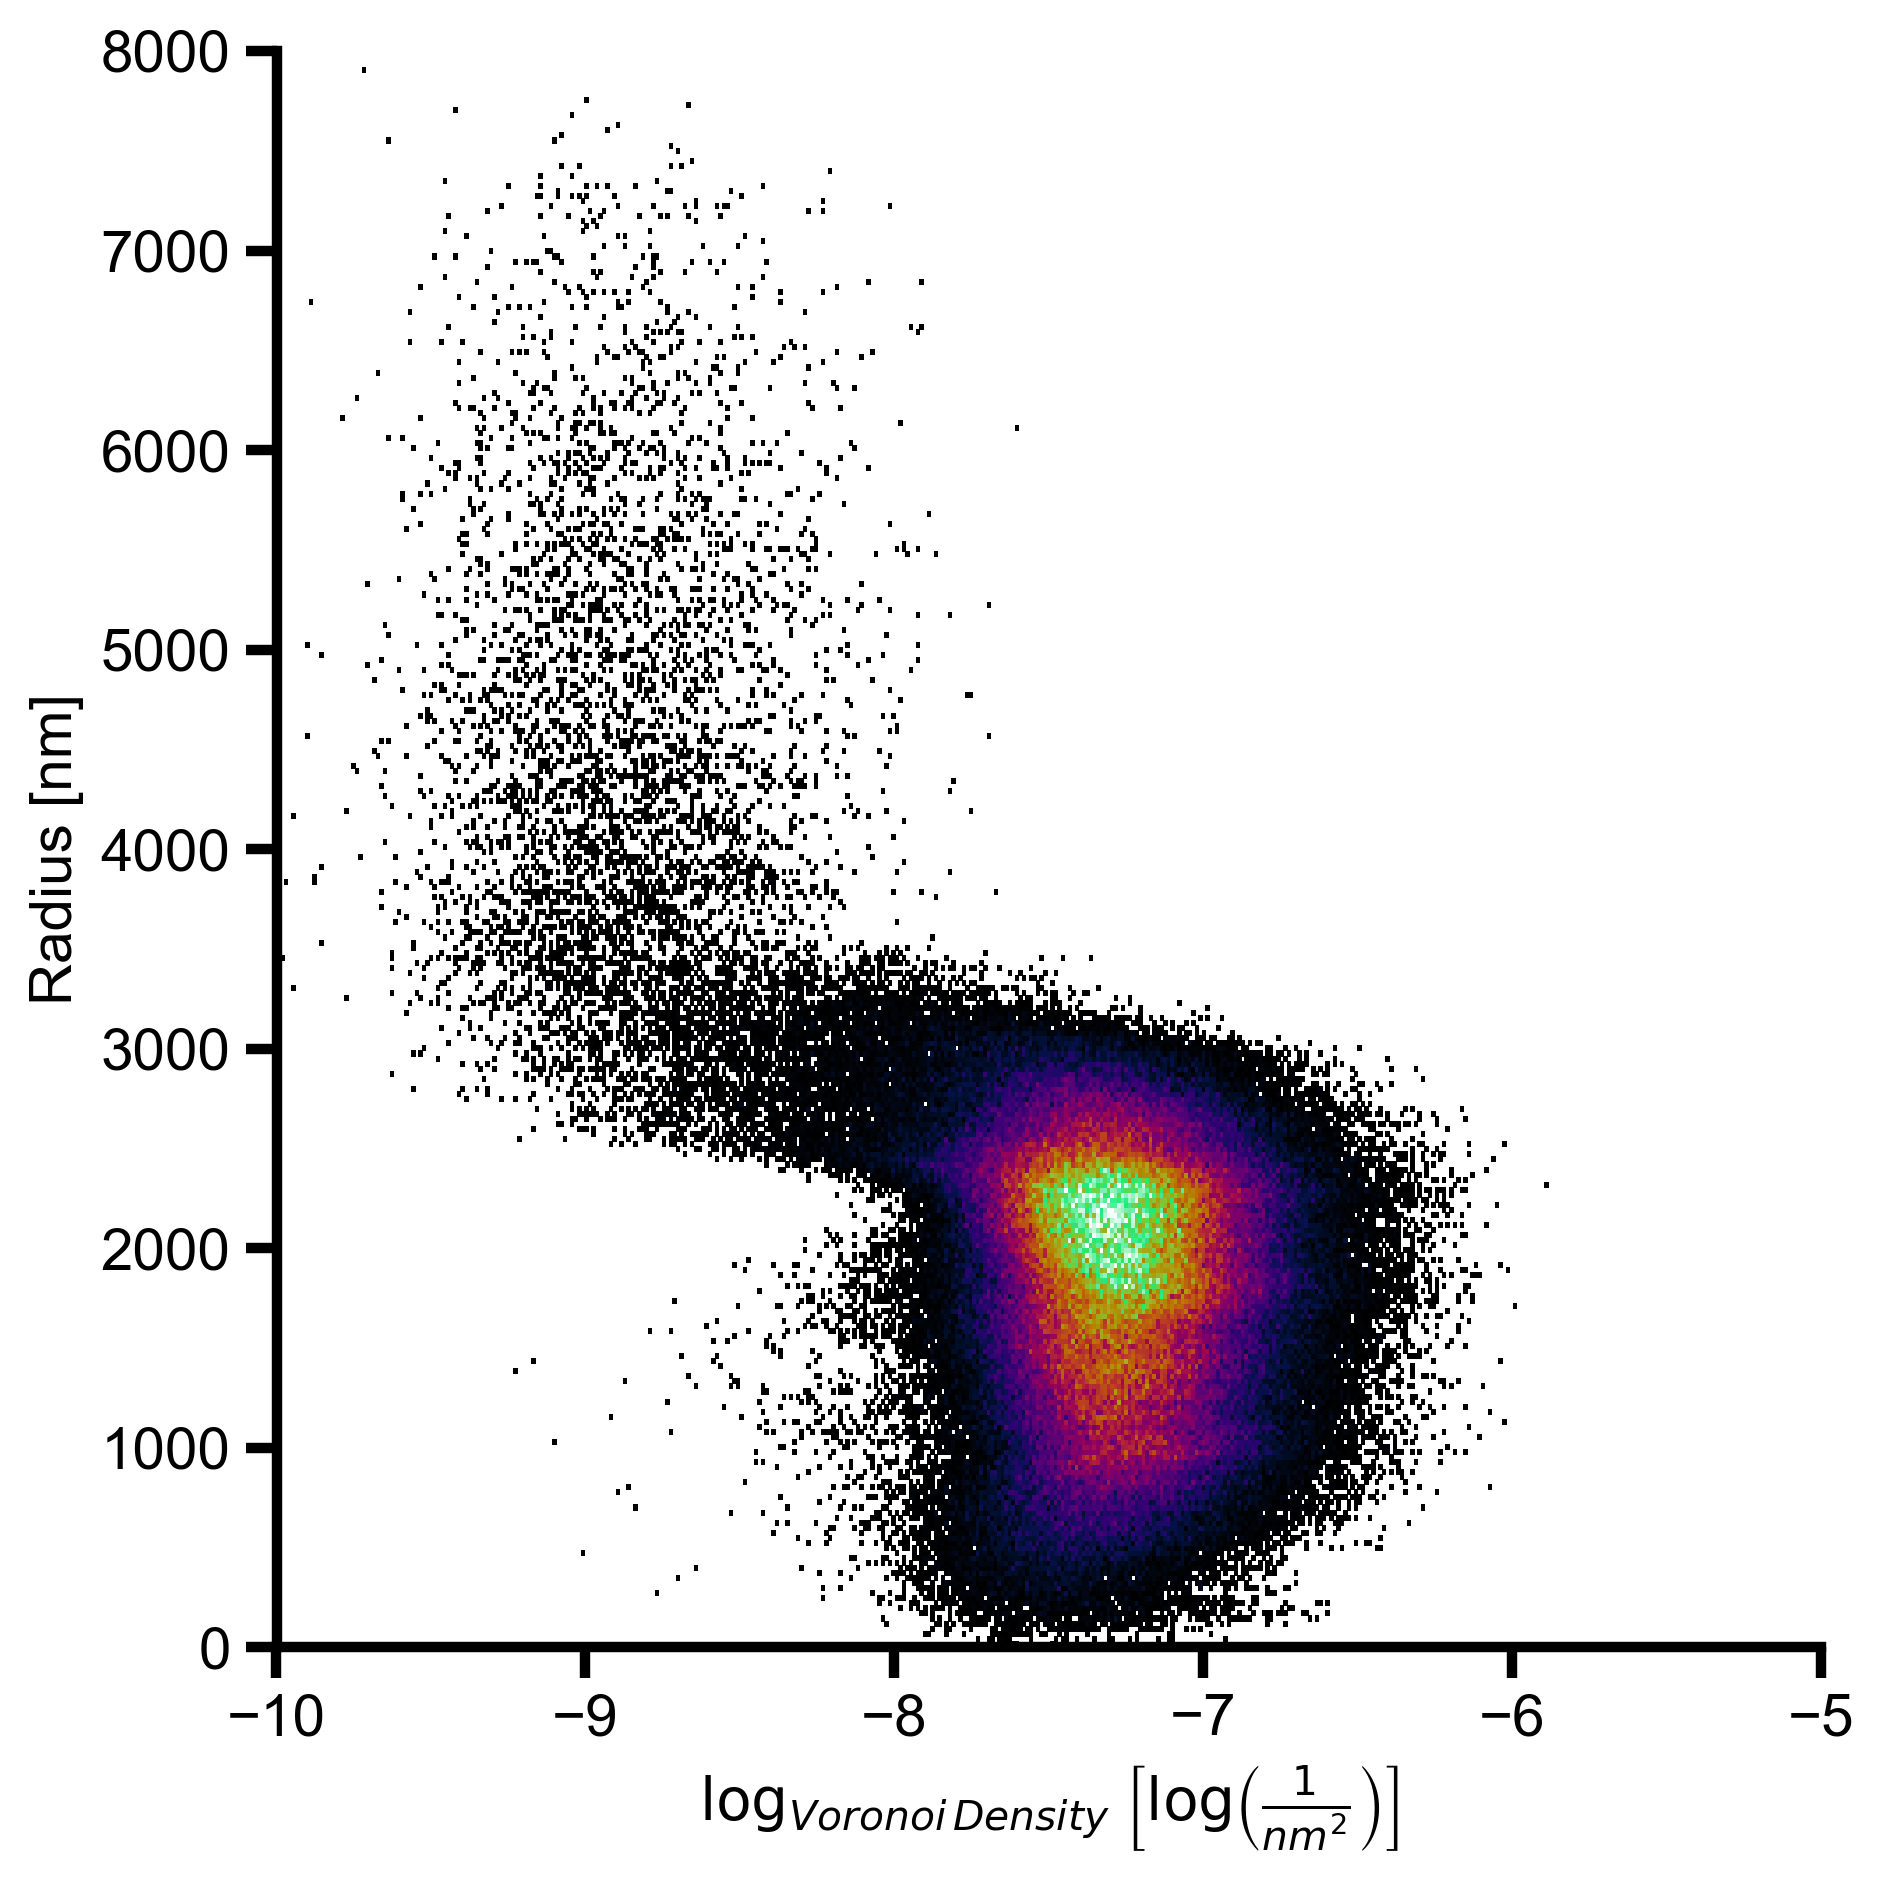

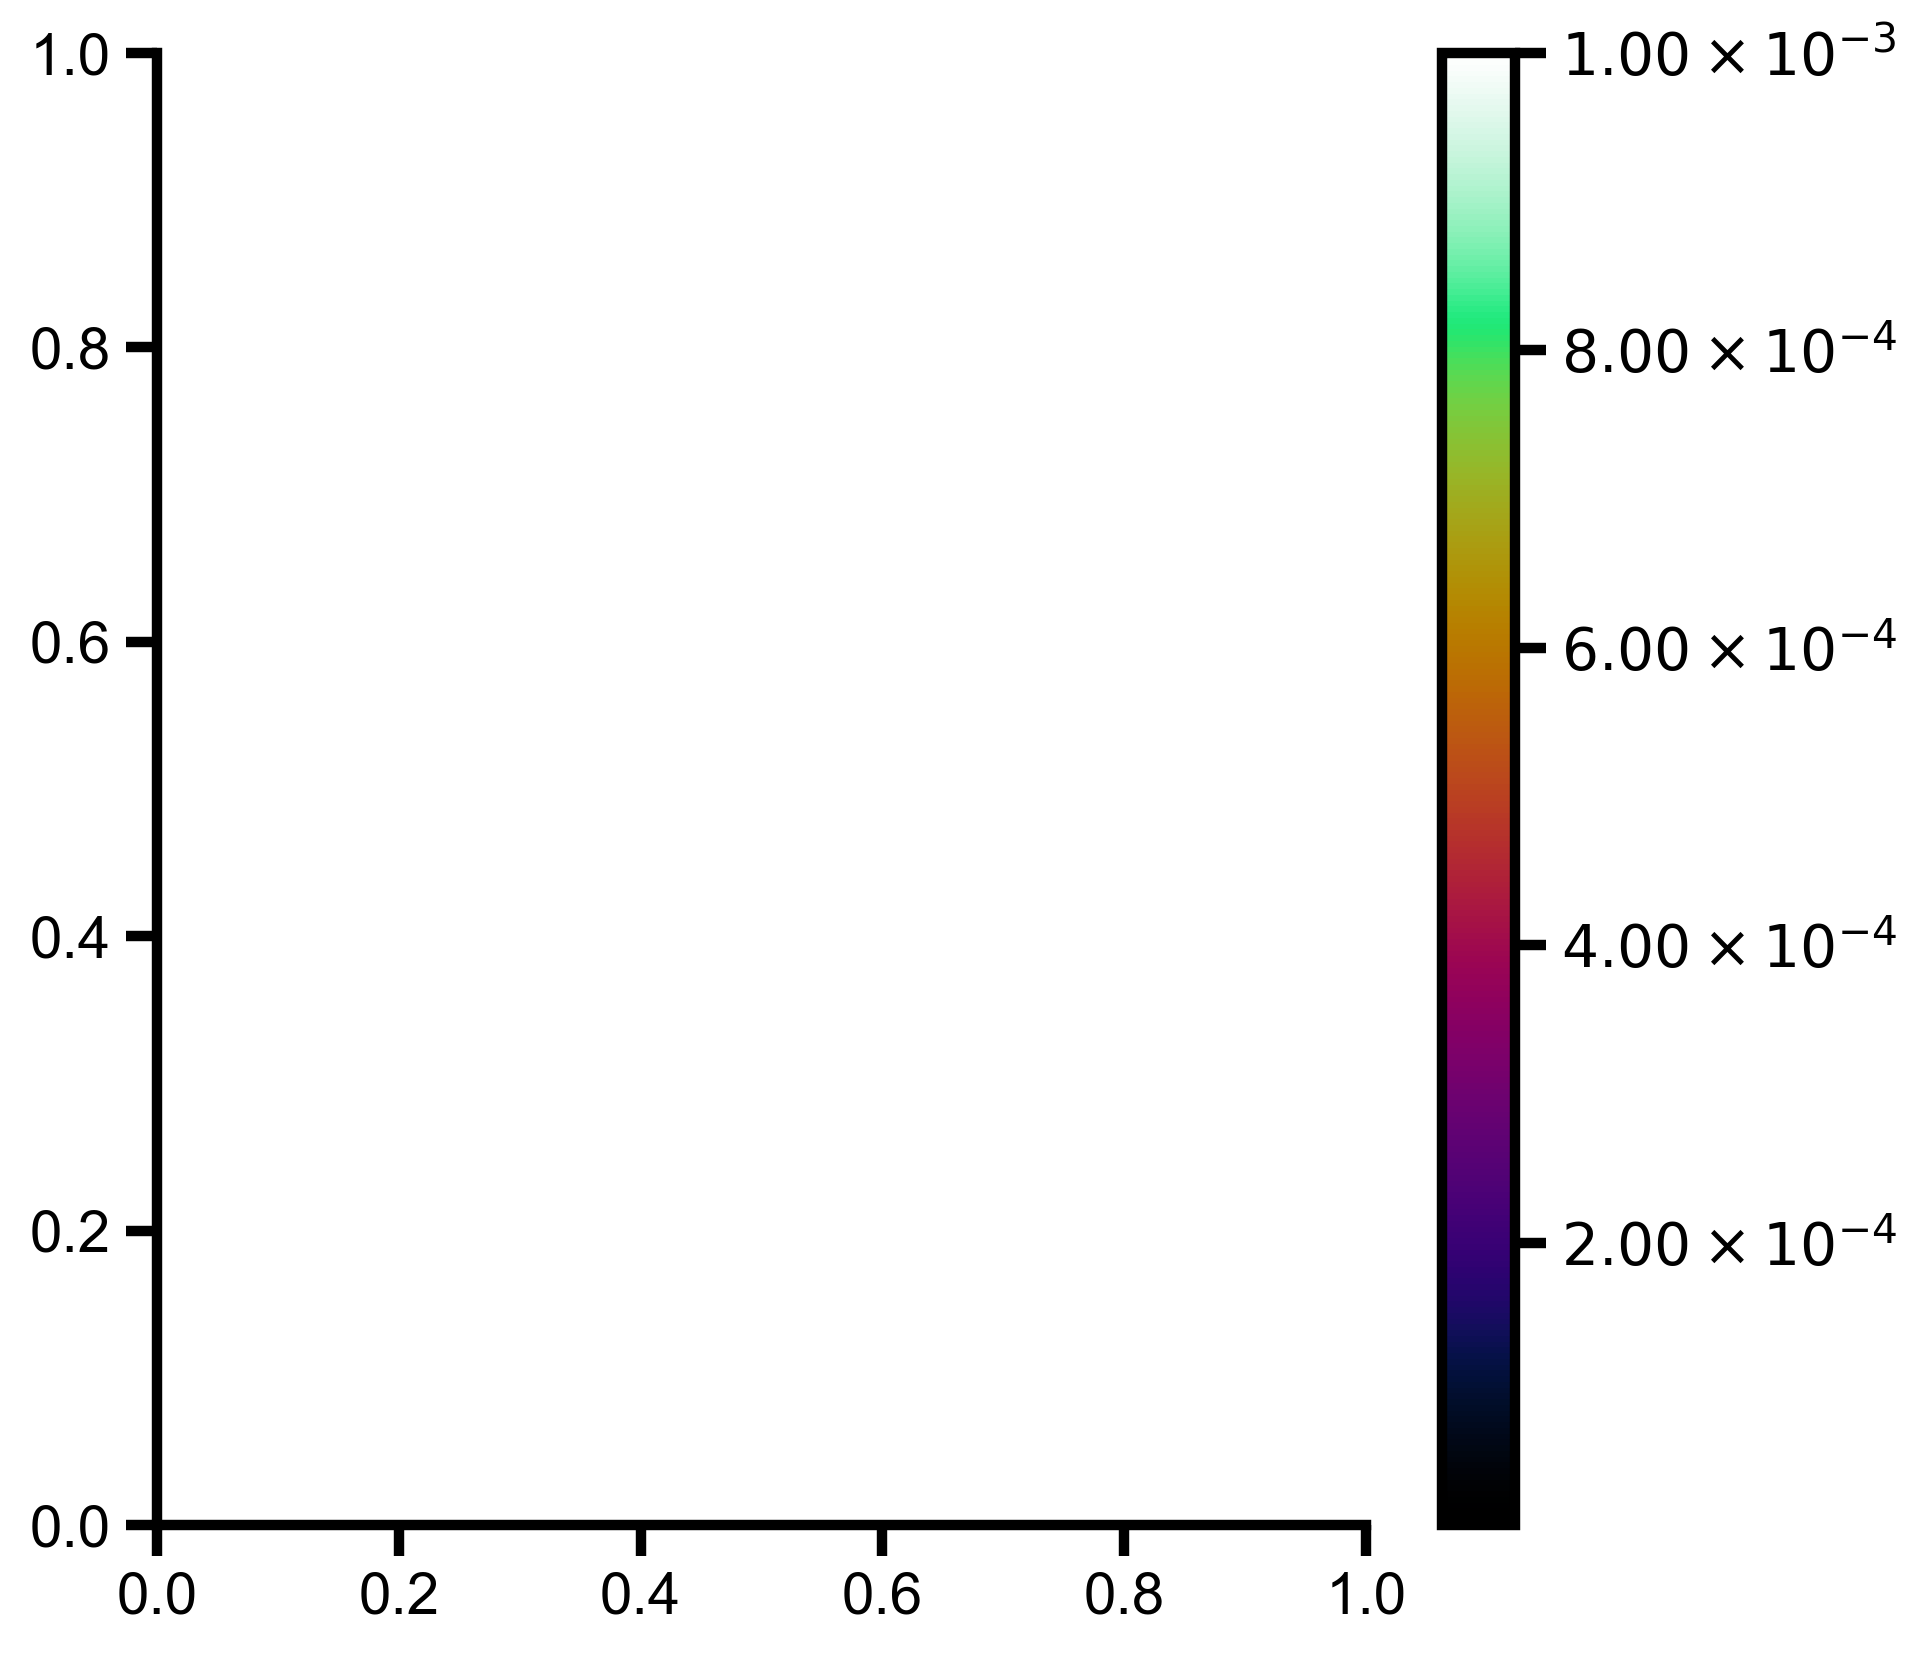

In [14]:
plot.plot_r_density_dist_stages_separate(
    data=filtered_cells,
    method=stage_method,
    stat=smlm_config.HIST_STAT,
    result_dir=result_dir_fig5,
    plot_col_density=plot_col,
    plot_label_density= plot_label,
)

Descriptive stage data

In [15]:
stats.describe_hist_distribution(
    filtered_cells,
    desc_col=plot_col,
    group=stage_method
).to_csv(result_dir.joinpath(f"voronoi_{plot_col}_{stage_method}_filtered.csv"))

Wilcoxon rank sums on stage density differences

In [16]:
wilcox_stats = stats.wilcoxon_rank_sums(plot_col, n_stages, stage_method, data=filtered_cells)
wilcox_stats.to_csv(result_dir.joinpath(f"wilcoxon_rank_sums_{plot_col}_{stage_method}.csv"),
                    index=False, float_format="%1.10f")